In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from label import label

In [2]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA


In [3]:
df = label("D:\\Project\\Bitcoin_Price_Prediction\\data\\binance-BTCUSDT-1m.csv", 15)

In [4]:
df.index = pd.to_datetime(df["Time_UTC_Start"])


# Extracting Relevant Series

In [5]:
# Create a new dataframe with one column - "spx"
data = pd.DataFrame(columns = ["spx"])
# Copy closing prices of S&P 500 to this new column
data["spx"] = df["Close"]
# Ensure that the dates are ordered in business week fashion (5 days a week)
data = data.asfreq('7200s')

In [6]:
data

,spx
Time_UTC_Start,
2018-07-18 10:39:00,7402.13
2018-07-18 12:39:00,7454.01
2018-07-18 14:39:00,7439.88
2018-07-18 16:39:00,7421.92
2018-07-18 18:39:00,7423.22
...,...
2022-05-06 22:39:00,36012.14
2022-05-07 00:39:00,36004.76
2022-05-07 02:39:00,35968.66


# Handling Missing Values

In [7]:
print("Null values - ",data.spx.isnull().sum())

print("\nStatistical Description of the series - ")
print(data.describe())

data.spx = data.spx.fillna(method='ffill')
print("\nNull values - ",data.spx.isnull().sum())

Null values -  121

Statistical Description of the series - 
                spx
count  16546.000000
mean   21777.702578
std    18824.961403
min     3180.860000
25%     7286.082500
50%    10337.910000
75%    39360.815000
max    68633.420000

Null values -  0


# Deriving S&P Returns and Volatility

$$Returns(t) = \frac{ Price(t) - Price(t-1) }{Price(t-1)} * 100$$
<br>
$$Volatility(t) = |Returns(t)|$$

In [8]:
# Calculating returns and volatility based on previous formulas
data["spx_ret"] = data.spx.pct_change(1).mul(100)
data["spx_vol"] = data.spx_ret.abs()

In [9]:
data.head()

,spx,spx_ret,spx_vol
Time_UTC_Start,,,
2018-07-18 10:39:00,7402.13,NaN,NaN
2018-07-18 12:39:00,7454.01,0.700879,0.700879
2018-07-18 14:39:00,7439.88,-0.189562,0.189562
2018-07-18 16:39:00,7421.92,-0.241402,0.241402
2018-07-18 18:39:00,7423.22,0.017516,0.017516


# Preliminary Line Plots

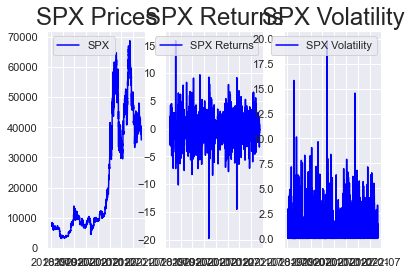

In [10]:
# Setting the figure size 
plt.rcParams["figure.figsize"] = (18, 5)

# Subdividing the figure into 3 figures stacked in 1 row
fig, ax = plt.subplots(1, 3)

# First Plot - S&P 500 prices against time
ax[0].plot(data.spx, color = "blue", label = "SPX")
ax[0].set_title("SPX Prices", size = 24)
ax[0].legend()

# Second Plot - S&P 500 returns against time
ax[1].plot(data.spx_ret, color = "blue", label = "SPX Returns")
ax[1].set_title("SPX Returns", size = 24)
ax[1].legend()

# Third Plot - S&P 500 volatility against time
ax[2].plot(data.spx_vol, color = "blue", label = "SPX Volatility")
ax[2].set_title("SPX Volatility", size = 24)
ax[2].legend()

# Used to display the plot free from any additional text in Jupyter notebooks
plt.show()

# Splitting Time Series Data into Train-Test sets

In [11]:
size = int(data.shape[0]*0.95)

In [12]:
train_df = data[:size]
test_df = data[size:]

print("Training Set Shape - ", train_df.shape)
print("Testing Set Shape - ", test_df.shape)

Training Set Shape -  (15833, 3)
Testing Set Shape -  (834, 3)


# Exploring Monthly Trends using Box Plots

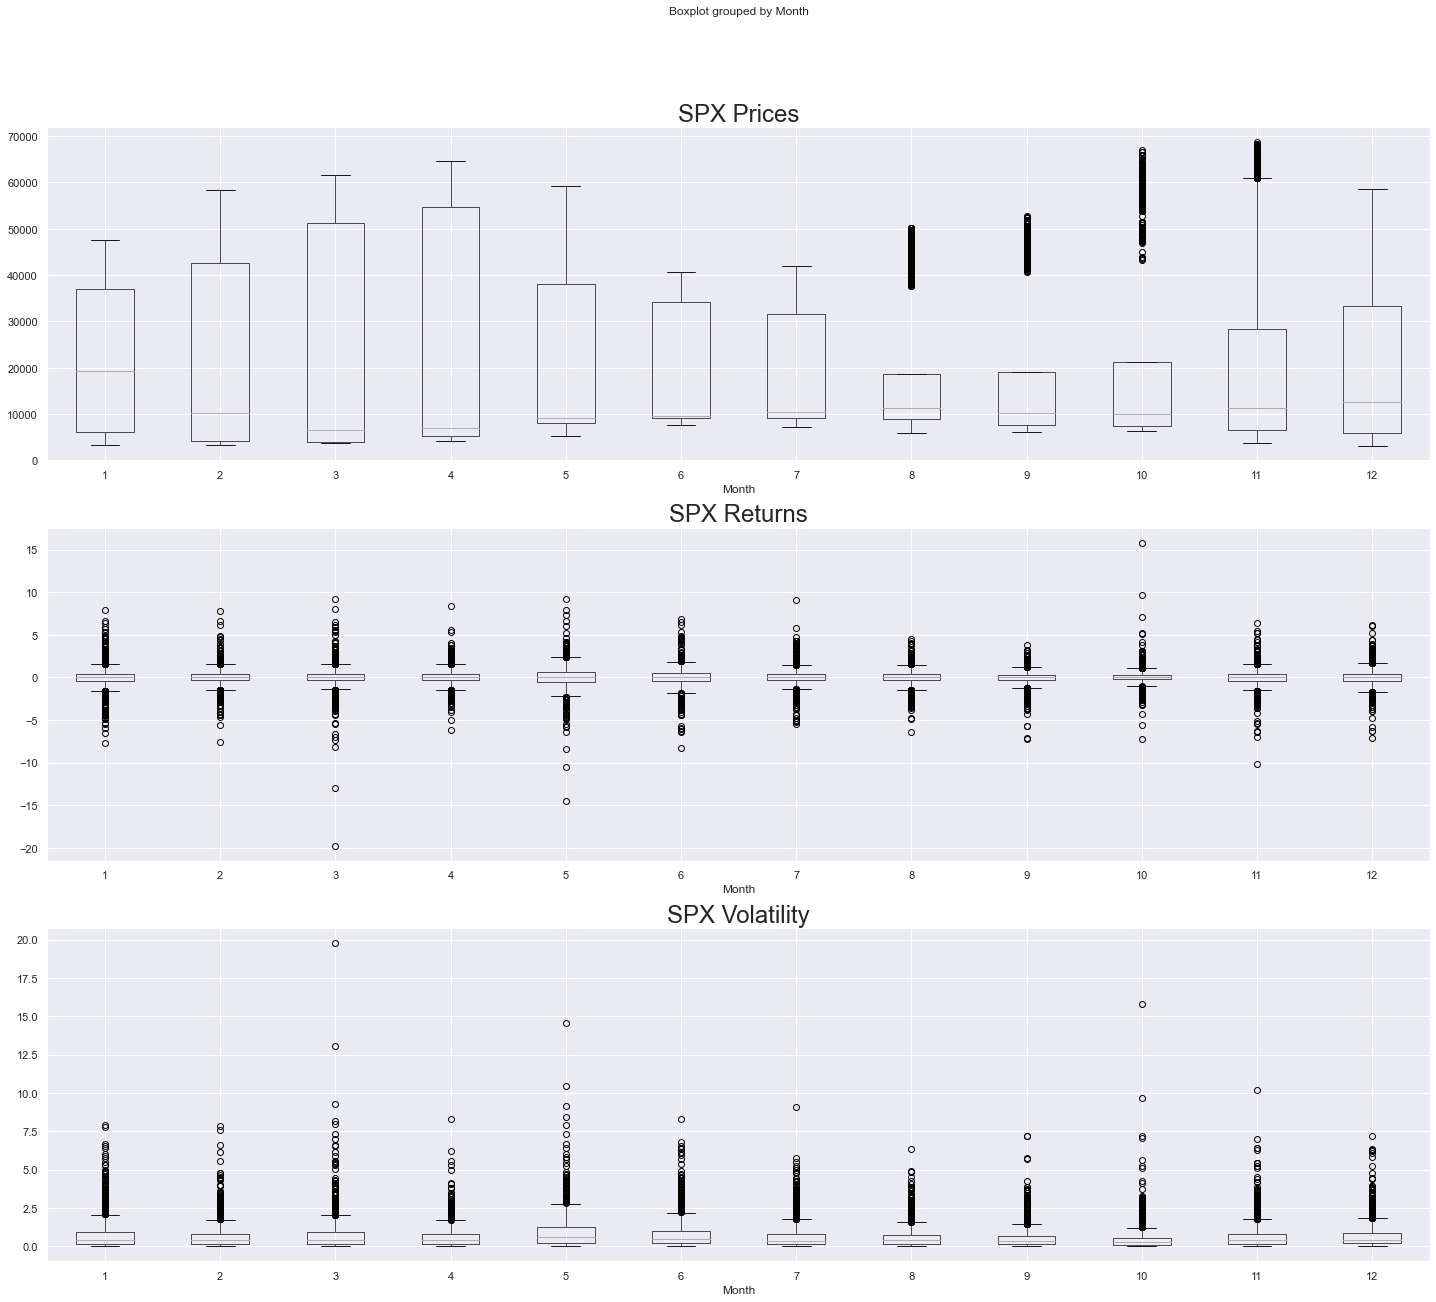

In [13]:
# Adding another column in train_df storing the "Year" of each observation
train_df["Month"] = train_df.index.month

# Setting the size of the figure 
plt.rcParams["figure.figsize"] = 24, 21

# Defining 3 subplots
fig, axes = plt.subplots(3, 1)

# First Boxplot: Yearly S&P 500 Prices
train_df.boxplot(by ='Month', column =['spx'], ax = axes[0])
axes[0].set_title("SPX Prices", size = 24)

# Second Boxplot: Yearly S&P 500 Returns
train_df.boxplot(by ='Month', column =['spx_ret'], ax = axes[1])
axes[1].set_title("SPX Returns", size = 24)

# Third Boxplot: Yearly S&P 500 Volatility
train_df.boxplot(by ='Month', column =['spx_vol'], ax = axes[2])
axes[2].set_title("SPX Volatility", size = 24)

# Displaying plots
plt.show()

# Distribution of Data

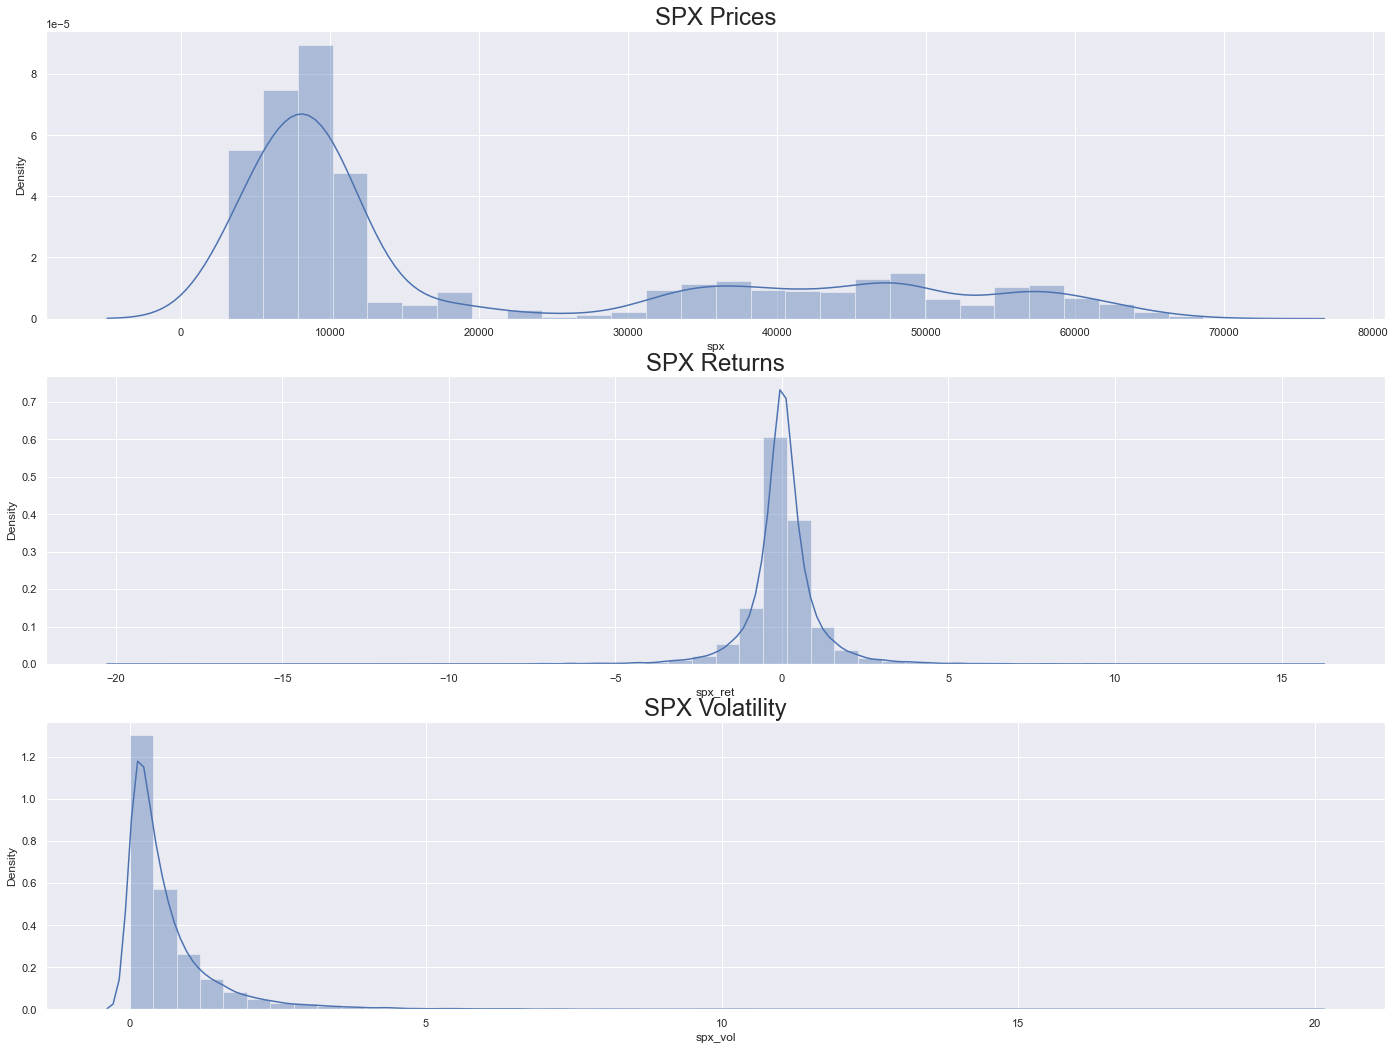

In [14]:
# Setting the figure size
plt.rcParams["figure.figsize"] = 24, 18

# Defining 3 subplots one below the other
fig, axes = plt.subplots(3, 1)

# Plotting the distributions in the respective subplots
sns.distplot(train_df.spx, ax = axes[0])
sns.distplot(train_df.spx_ret, ax = axes[1])
sns.distplot(train_df.spx_vol, ax = axes[2])

# Setting the title for each subplot
axes[0].set_title("SPX Prices", size = 24)
axes[1].set_title("SPX Returns", size = 24)
axes[2].set_title("SPX Volatility", size = 24)

# Displaying the plot
plt.show()

# Data Decomposition (Additive and Multiplicative)

### Additive decomposition
<br>
$y_t = T_t + S_t + R_t$ 
<br>
where:
<br>
$y_t: Value at time interval t$
<br>
$T_t: Trend at time interval t$
<br>
$S_t: Seasonality at time interval t$
<br>
$R_t: Residual at time interval t$

### Multiplicative decomposition
<br>
$y_t = T_t * S_t * R_t$ 
<br>
where:
<br>
$y_t: Value at time interval t$
<br>
$T_t: Trend at time interval t$
<br>
$S_t: Seasonality at time interval t$
<br>
$R_t: Residual at time interval t$

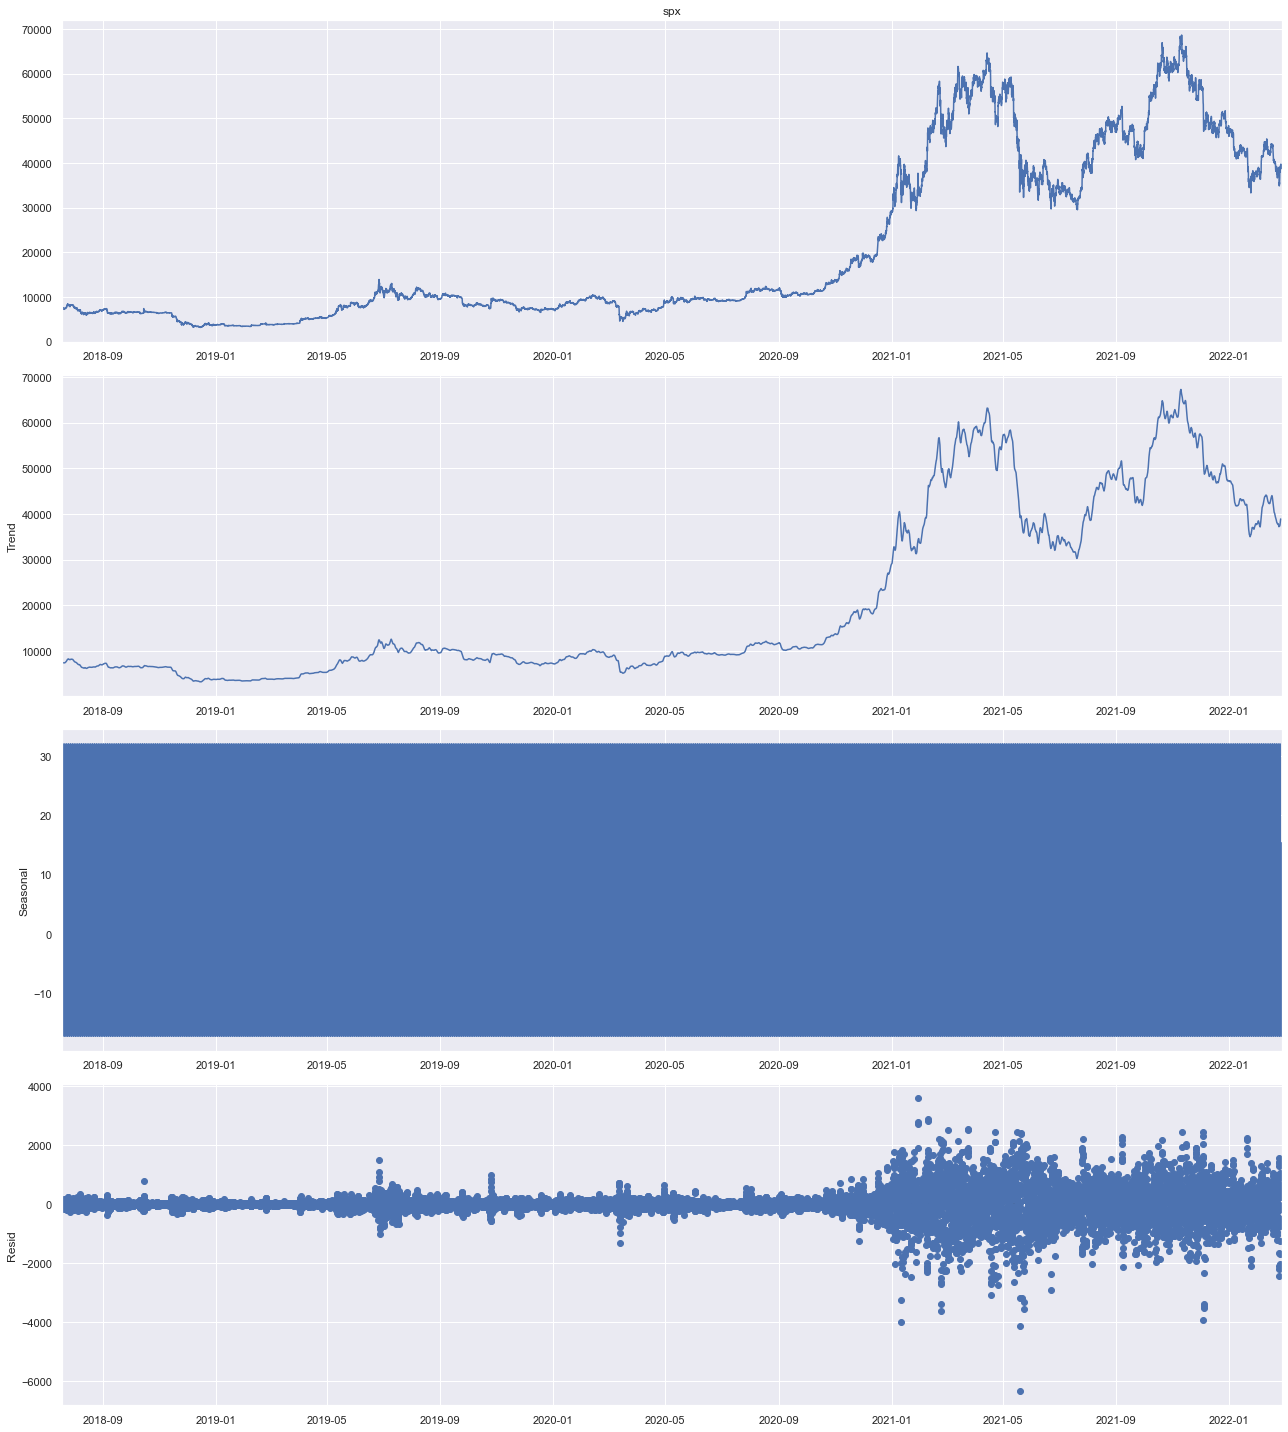

In [15]:
# Import the required package
from statsmodels.tsa.seasonal import seasonal_decompose

# Set Plot size
plt.rcParams["figure.figsize"] = 18, 20

# Call the seasonal_decompose method to decompose the data using the "additive" model 
result = seasonal_decompose(train_df.spx, model='additive')

# Un-comment these lines for additive decomposition of S&P 500 Returns and Volatility respectively
# result = seasonal_decompose(train_df.spx_ret[1:], model='additive')
# result = seasonal_decompose(train_df.spx_vol[1:], model='additive')

# Un-comment these lines for multiplicative decomposition of S&P 500 Prices, Returns and Volatility respectively
# result = seasonal_decompose(train_df.spx, model='multiplicative')
# result = seasonal_decompose(train_df.spx_ret[1:], model='multiplicative')
# result = seasonal_decompose(train_df.spx_vol[1:], model='multiplicative')

# Plot the result
result.plot()

# Display the plot
plt.show()

# Seasonal Component

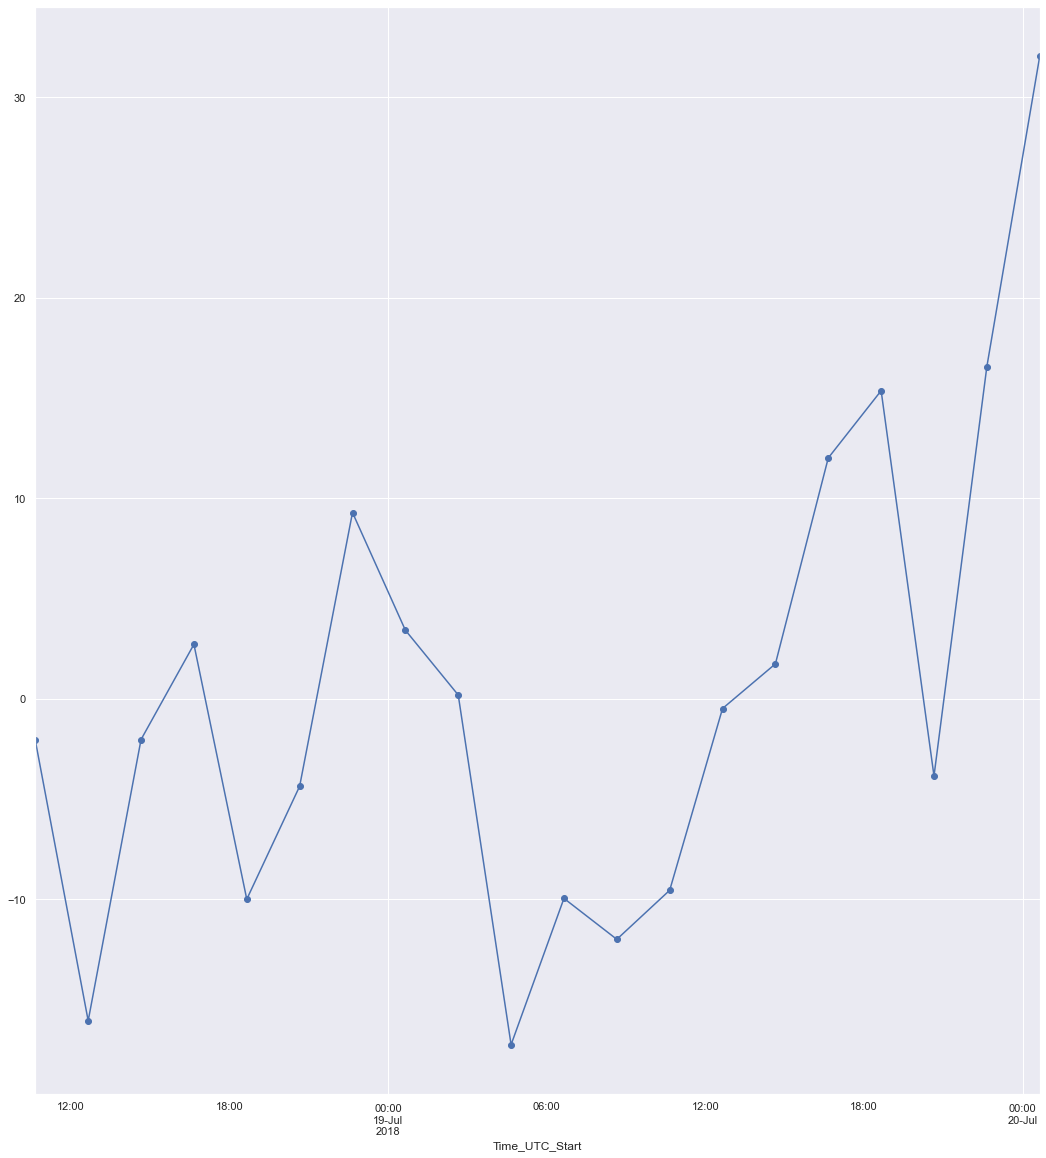

In [16]:
result.seasonal[:20].plot(marker = "o")
plt.show()

# Smoothing the Time Series (Moving Averages)

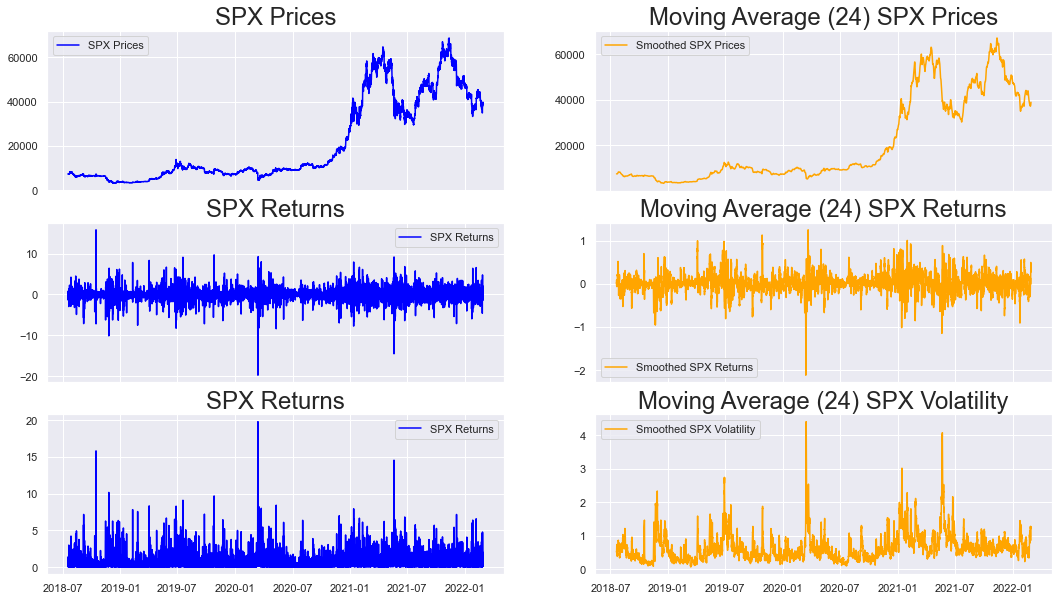

In [17]:
# Setting the Plot size
plt.rcParams["figure.figsize"] = 18, 10

# Defining the number of subplots. sharex = True enables the plots to share their x axis and its labels
fig, ax = plt.subplots(3, 2, sharex = True)

# Plots for Moving Average (window = 24) of S&P 500 Prices 
ax[0, 0].plot(train_df.spx, color = "blue", label = "SPX Prices")
ax[0, 0].set_title("SPX Prices", size = 24)
ax[0, 0].legend()

ax[0, 1].plot(train_df.spx.rolling(window=24).mean(), color = "orange", label = "Smoothed SPX Prices")
ax[0, 1].set_title("Moving Average (24) SPX Prices", size = 24)
ax[0, 1].legend()

# Plots for Moving Average (window = 24) of S&P 500 Returns
ax[1, 0].plot(train_df.spx_ret[1:], color = "blue", label = "SPX Returns")
ax[1, 0].set_title("SPX Returns", size = 24)
ax[1, 0].legend()

ax[1, 1].plot(train_df.spx_ret[1:].rolling(window=24).mean(), color = "orange", label = "Smoothed SPX Returns")
ax[1, 1].set_title("Moving Average (24) SPX Returns", size = 24)
ax[1, 1].legend()

# Plots for Moving Average (window = 24) of S&P 500 Volatility
ax[2, 0].plot(train_df.spx_vol[1:], color = "blue", label = "SPX Returns")
ax[2, 0].set_title("SPX Returns", size = 24)
ax[2, 0].legend()

ax[2, 1].plot(train_df.spx_vol[1:].rolling(window=24).mean(), color = "orange", label = "Smoothed SPX Volatility")
ax[2, 1].set_title("Moving Average (24) SPX Volatility", size = 24)
ax[2, 1].legend()

# Displaying Plots
plt.show()

# Correlation Plots (ACF and PACF)

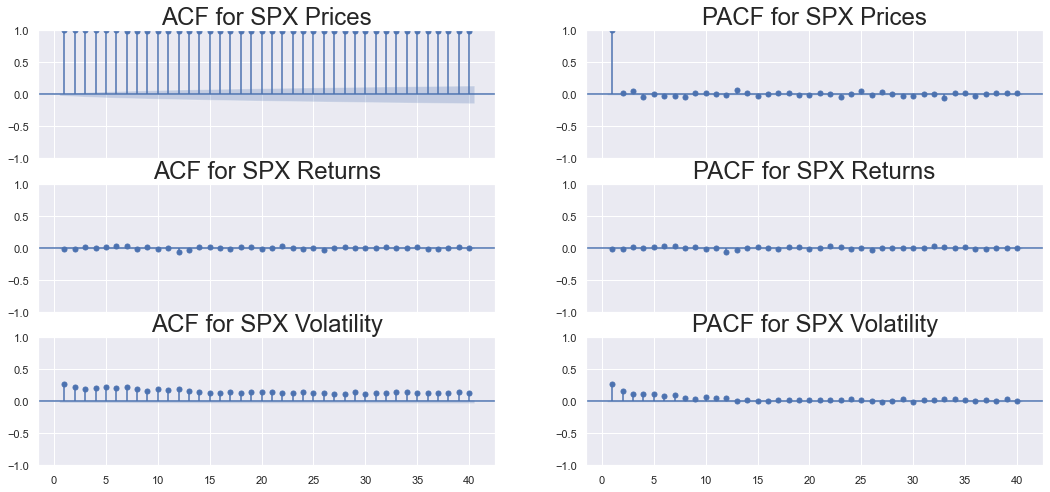

In [18]:
# Importing the required packages
import statsmodels.graphics.tsaplots as sgt

# Setting the size of the figure
plt.rcParams["figure.figsize"] = 18, 8

# Defining the subplots with shared x-axis
fig, axes = plt.subplots(3, 2, sharex = True)

# Plotting ACF for S&P 500 Prices, Returns and Volatility
sgt.plot_acf(train_df.spx, zero = False, lags = 40, ax = axes[0, 0])
sgt.plot_acf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[1, 0])
sgt.plot_acf(train_df.spx_vol[1:], zero = False, lags = 40, ax = axes[2, 0])

axes[0, 0].set_title("ACF for SPX Prices", size = 24)
axes[1, 0].set_title("ACF for SPX Returns", size = 24)
axes[2, 0].set_title("ACF for SPX Volatility", size = 24)

# Plotting PACF for S&P 500 Prices, Returns and Volatility
sgt.plot_pacf(train_df.spx, zero = False, lags = 40, ax = axes[0, 1])
sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[1, 1])
sgt.plot_pacf(train_df.spx_vol[1:], zero = False, lags = 40, ax = axes[2, 1])

axes[0, 1].set_title("PACF for SPX Prices", size = 24)
axes[1, 1].set_title("PACF for SPX Returns", size = 24)
axes[2, 1].set_title("PACF for SPX Volatility", size = 24)

# Displaying the plots
plt.show()

# Visual Inspection

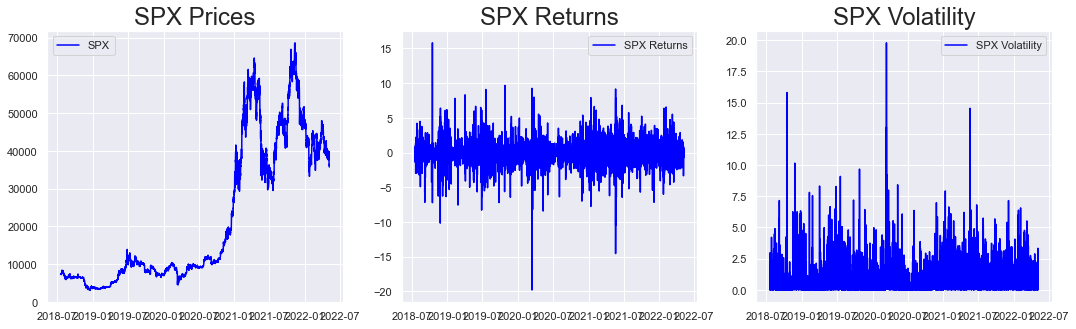

In [19]:
# Setting the figure size 
plt.rcParams["figure.figsize"] = (18, 5)

# Subdividing the figure into 3 figures stacked in 1 row
fig, ax = plt.subplots(1, 3)

# First Plot - S&P 500 prices against time
ax[0].plot(data.spx, color = "blue", label = "SPX")
ax[0].set_title("SPX Prices", size = 24)
ax[0].legend()

# Second Plot - S&P 500 returns against time
ax[1].plot(data.spx_ret, color = "blue", label = "SPX Returns")
ax[1].set_title("SPX Returns", size = 24)
ax[1].legend()

# Third Plot - S&P 500 volatility against time
ax[2].plot(data.spx_vol, color = "blue", label = "SPX Volatility")
ax[2].set_title("SPX Volatility", size = 24)
ax[2].legend()

# Used to display the plot free from any additional text in Jupyter notebooks
plt.show()

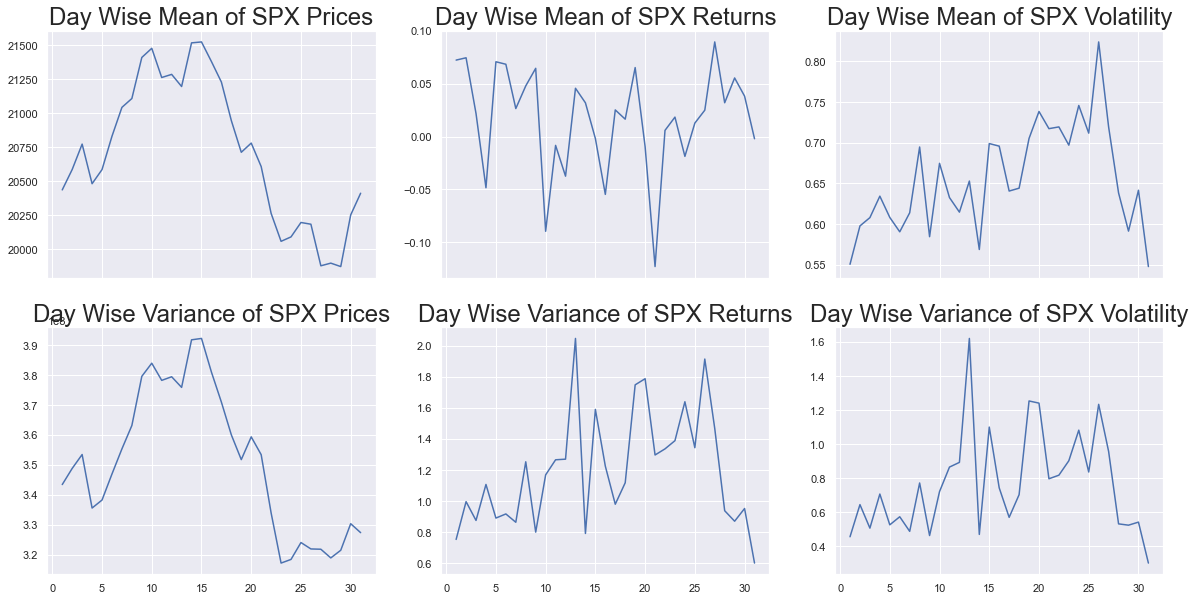

In [20]:
# Building dataframes to store yearly mean and variance
mean_df = train_df.groupby(by = train_df.index.day).mean()
var_df = train_df.groupby(by = train_df.index.day).var()

# Setting the figure size
plt.rcParams["figure.figsize"] = 20, 10

# Defining the subplots with shared x-axis
fig, ax = plt.subplots(2, 3, sharex = True)

# PLotting mean for the 3 series in the first row
ax[0, 0].plot(mean_df.spx)
ax[0, 1].plot(mean_df.spx_ret)
ax[0, 2].plot(mean_df.spx_vol)

# Setting title for the first row of plots
ax[0, 0].set_title("Day Wise Mean of SPX Prices", size = 24)
ax[0, 1].set_title("Day Wise Mean of SPX Returns", size = 24)
ax[0, 2].set_title("Day Wise Mean of SPX Volatility", size = 24)


# PLotting variance for the 3 series in the second row
ax[1, 0].plot(var_df.spx)
ax[1, 1].plot(var_df.spx_ret)
ax[1, 2].plot(var_df.spx_vol)

# Setting title for the second row of plots
ax[1, 0].set_title("Day Wise Variance of SPX Prices", size = 24)
ax[1, 1].set_title("Day Wise Variance of SPX Returns", size = 24)
ax[1, 2].set_title("Day Wise Variance of SPX Volatility", size = 24)

# Displaying the plots
plt.show()

# Statistical Tests (ADF)

In [21]:

# Importing the necessary package
from statsmodels.tsa.stattools import adfuller

# ADF test in S&P 500 Prices
print(adfuller(train_df["spx"]))

# To apply ADF Test on S&P 500 Returns, use the code line below
print(adfuller(train_df["spx_ret"][1:]))

# To apply ADF Test on S&P 500 volatility, use the code line below
print(adfuller(train_df["spx_vol"][1:]))

(-0.8507408184086619, 0.803761307602716, 42, 15790, {'1%': -3.4307642092081374, '5%': -2.8617230632238755, '10%': -2.566867440018835}, 227055.32376994047)
(-20.92983268067091, 0.0, 36, 15795, {'1%': -3.4307640780664617, '5%': -2.8617230052687566, '10%': -2.5668674091700594}, 47698.236443443384)
(-9.714989823423956, 9.884433564670434e-17, 40, 15791, {'1%': -3.430764182973157, '5%': -2.861723051629915, '10%': -2.566867433847517}, 38021.41428749464)


In [22]:
train_df.spx_ret[:].shape

(15833,)

# Non Seasonal Models : ARIMA

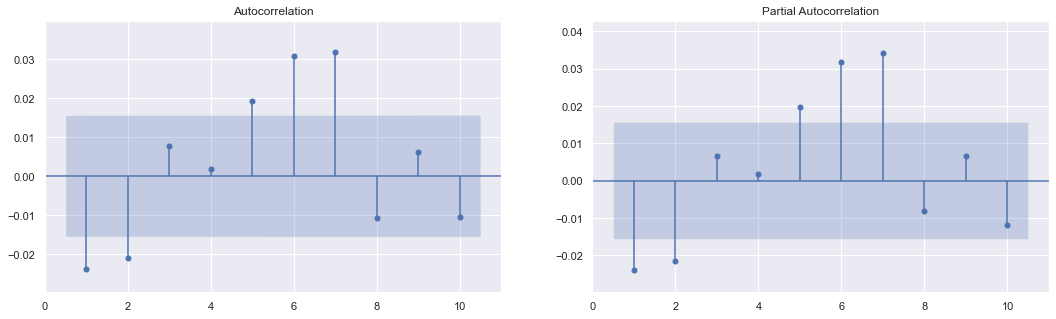

In [23]:
# Importing Required Package
import statsmodels.graphics.tsaplots as sgt

# Fixing plot size
plt.rcParams["figure.figsize"] = 18, 5

# Defining Subplots
fig, axes = plt.subplots(1, 2)

# Plotting ACF and PACF for S&P 500 Returns
sgt.plot_acf(train_df.spx_ret[1:], zero = False, lags = 10, ax = axes[0], auto_ylims = True)
sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 10, ax = axes[1], auto_ylims = True)

# Display the Plot
plt.show()

# Fitting ARIMA(1, 0, 1)

                               SARIMAX Results                                
Dep. Variable:                spx_ret   No. Observations:                15832
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -23971.737
Date:                Tue, 07 Jun 2022   AIC                          47951.475
Time:                        10:17:10   BIC                          47982.154
Sample:                    07-18-2018   HQIC                         47961.627
                         - 02-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0166      0.009      1.936      0.053      -0.000       0.033
ar.L1          0.3064      0.139      2.204      0.028       0.034       0.579
ma.L1         -0.3332      0.138     -2.412      0.0

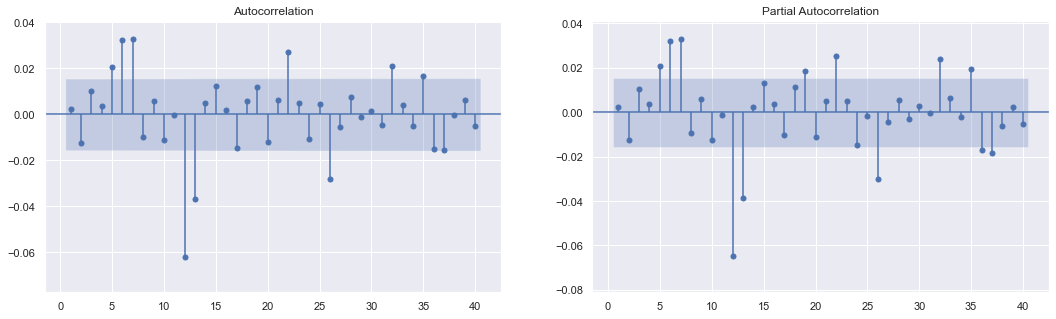

In [24]:
# MODEL FITTING
# Importing Required Package
from statsmodels.tsa.arima.model import ARIMA

# Defining the Model
model = ARIMA(train_df["spx_ret"][1:], order = (1, 0, 1))
# Fitting the Model
model_results = model.fit()

# Printing the model summary
print(model_results.summary())


# EVALUATING RESIDUALS
# Defining the figure size
plt.rcParams["figure.figsize"] = 18, 5

# Defining the subplots 
fig, axes = plt.subplots(1, 2)

# ACF and PACF for residuals of ARIMA(1, 0, 1)
sgt.plot_acf(model_results.resid[1:], zero = False, lags = 40, ax = axes[0],auto_ylims = True)
sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40, ax = axes[1], auto_ylims= True)

# Displaying the plots
plt.show()

# Tuning parameter for ARIMA


In [25]:
p_range = [x for x in range(1,6)]
q_range = [x for x in range(1,6)]
d_range = [x for x in range(1,3)]
res = float('infinity')
order = None
for p in (p_range):
    for q in (q_range):
        for d in (d_range):
            model = ARIMA(train_df["spx_ret"][1:], order = (p, d, q))
            model_fit = model.fit()
            if model_fit.aic < res:
                res = model_fit.aic
                order = (p,d,q)

C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood opt

In [26]:
print("best order: ", order)
print("AIC value: ",res)

best order:  (5, 1, 3)
AIC value:  47944.81651194773


# Fitting ARIMA model (5, 1, 3)


C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                spx_ret   No. Observations:                15832
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -23963.408
Date:                Tue, 07 Jun 2022   AIC                          47944.817
Time:                        10:29:54   BIC                          48013.844
Sample:                    07-18-2018   HQIC                         47967.659
                         - 02-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8415      0.005   -390.123      0.000      -1.851      -1.832
ar.L2         -1.0535      0.008   -127.333      0.000      -1.070      -1.037
ar.L3         -0.0527      0.010     -5.347      0.0

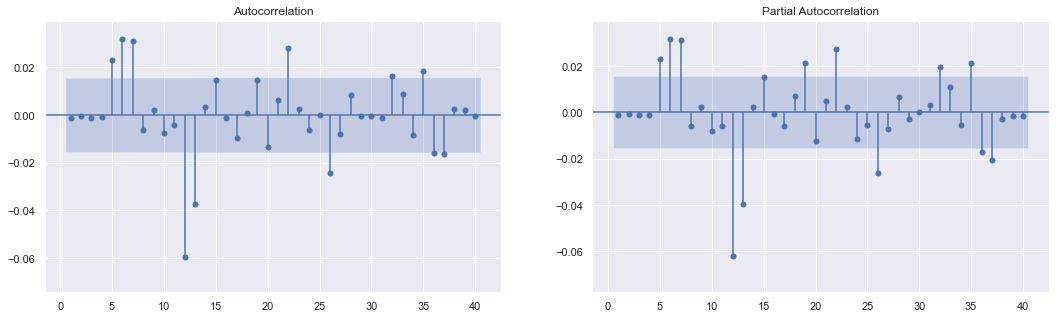

In [27]:
model = ARIMA(train_df["spx_ret"][1:], order = (5, 1, 3))
model_results = model.fit()
print(model_results.summary())


# EVALUATING RESIDUALS
# Defining the figure size
plt.rcParams["figure.figsize"] = 18, 5

# Defining the subplots 
fig, axes = plt.subplots(1, 2)

# ACF and PACF for residuals of ARIMA(1, 0, 1)
sgt.plot_acf(model_results.resid[1:], zero = False, lags = 40, ax = axes[0],auto_ylims = True)
sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40, ax = axes[1], auto_ylims= True)

# Displaying the plots
plt.show()

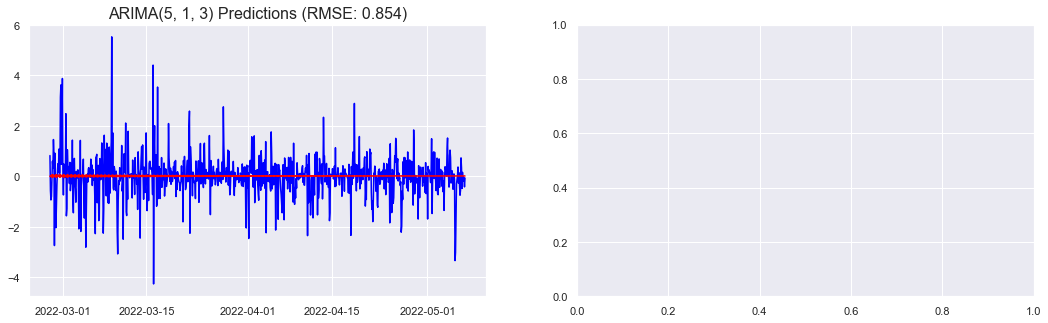

In [28]:
from sklearn.metrics import mean_squared_error
# Forecasts of ARIMA model
pred = model_results.predict(start = test_df.index[0], end = test_df.index[-1])
# RMSE of ARIMA model
arima_rmse = np.sqrt(mean_squared_error(y_true = test_df["spx_ret"].values, y_pred = pred.values))

# FORECAST vs ACTUALS PLOT
# Setting the size of the figure
plt.rcParams["figure.figsize"] = 18, 5

# Defining the subplots
fig, ax = plt.subplots(1, 2)

# Actuals vs Predictions for ARIMA(5, 1, 3)
ax[0].plot(test_df["spx_ret"], color = "blue", label = "Actuals")
ax[0].plot(pred, color = "red", label = "ARIMA(5, 1, 3) Predictions")
ax[0].set_title(f"ARIMA(5, 1, 3) Predictions (RMSE: {np.round(arima_rmse, 3)})", size = 16)

# Displaying the plots
plt.show()

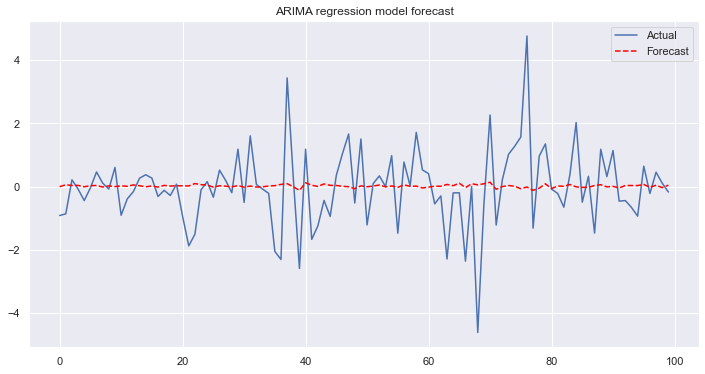

In [29]:
pred = model_results.predict()

plt.figure(figsize=(12, 6))
plt.plot(train_df["spx_ret"].to_list()[-100:], label='Actual')
plt.plot(pred.to_list()[-100:], color='red', linestyle='--', label = 'Forecast')
plt.legend()
plt.title('ARIMA regression model forecast')
plt.show()

                     lower spx_ret  upper spx_ret  Predictions
2022-02-26 20:39:00      -2.158295       2.145240    -0.006527
2022-02-26 22:39:00      -2.119932       2.184630     0.032349
2022-02-27 00:39:00      -2.125632       2.179902     0.027135
2022-02-27 02:39:00      -2.169459       2.136276    -0.016592
2022-02-27 04:39:00      -2.089422       2.216342     0.063460


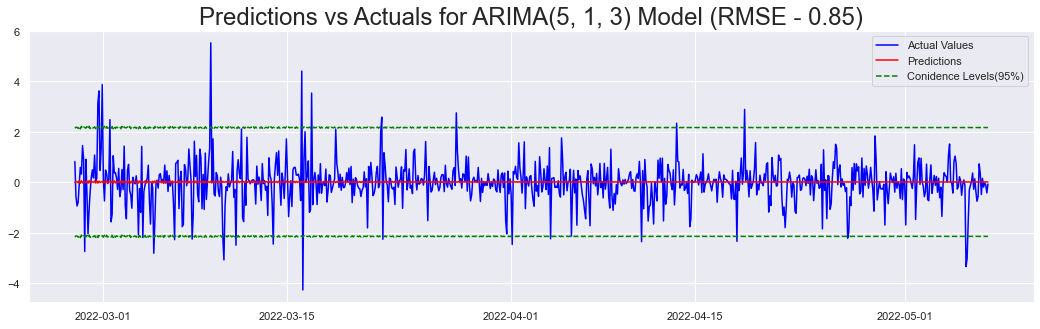

In [30]:

# FORECASTING AND CONFIDENCE INTERVALS
# Generating Forecast object
forecasts = model_results.get_forecast(len(test_df.index))
# Generating confidence intervals
forecasts_df = forecasts.conf_int(alpha = 0.05)  # Confidence Interval of 95%
# Actual predictions
forecasts_df["Predictions"] = model_results.predict(start = test_df.index[0], end = test_df.index[-1])

# Displaying first 5 rows of the forecasts_df
print(forecasts_df.head())

# RMSE of the forecasts
arima_rmse = np.sqrt(mean_squared_error(y_true = test_df["spx_ret"].values, y_pred = forecasts_df["Predictions"].values))


# PLOTTING THE FORECASTS AND CONFIDENCE INTERVALS
# Setting the figure size
plt.rcParams["figure.figsize"] = 18, 5

# Actual values of the S&P 500 returns in the test set
plt.plot(test_df["spx_ret"], color = "blue", label = "Actual Values")

# Predictions from the model and confidence intervals
plt.plot(forecasts_df["Predictions"], color = "red", label = "Predictions")
plt.plot(forecasts_df["upper spx_ret"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(forecasts_df["lower spx_ret"], color = "green", linestyle = "--")

# Title of the plot
plt.title(f"Predictions vs Actuals for ARIMA(5, 1, 3) Model (RMSE - {round(arima_rmse, 2)})", size = 24)

# Display the labels
plt.legend()
# Display the plot
plt.show()


# We will now use the spx columns to estimate the ARIMA models

In [31]:
r_t = train_df["spx"]

# Tuning parameters

In [32]:
p_range = [x for x in range(1,6)]
q_range = [x for x in range(1,6)]
d_range = [x for x in range(1,3)]
res = float('infinity')
order = None
for p in (p_range):
    for q in (q_range):
        for d in (d_range):
            model = ARIMA(r_t, order = (p, d, q))
            model_fit = model.fit()
            if model_fit.aic < res:
                res = model_fit.aic
                order = (p,d,q)

C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood opt

In [33]:
print("best order: ", order)
print("AIC value: ",res)

best order:  (5, 1, 5)
AIC value:  227758.89669299708


In [34]:
model = ARIMA(r_t, order = order)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Nguyen The Minh Duc\anaconda3\envs\stan_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                    spx   No. Observations:                15833
Model:                 ARIMA(5, 1, 5)   Log Likelihood             -113868.448
Date:                Tue, 07 Jun 2022   AIC                         227758.897
Time:                        10:39:08   BIC                         227843.264
Sample:                    07-18-2018   HQIC                        227786.815
                         - 02-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3546      0.010     37.287      0.000       0.336       0.373
ar.L2          0.0822      0.012      7.101      0.000       0.059       0.105
ar.L3          0.0846      0.011      8.034      0.0

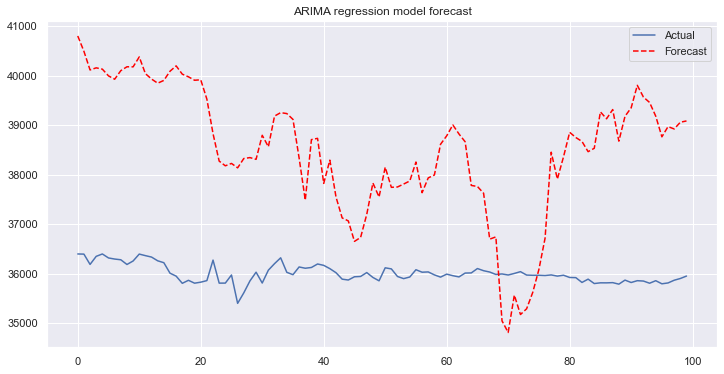

In [35]:
pred = model_fit.predict()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'].to_list()[-100:], label='Actual')
plt.plot(pred.to_list()[-100:], color='red', linestyle='--', label = 'Forecast')
plt.legend()
plt.title('ARIMA regression model forecast')
plt.show()

# Forecasting Volatility using GARCH


__GARCH model__ uses the concept of volatility clustering to model the volatility of a series. __Volatility Clustering__ essentially means that the volatility today, depends on the volatility at recent time steps.
<br>
A GARCH model is specified using 2 parameters: __GARCH(p, q).__ The GARCH model is formulated as shown below.
<br>
$$
Var(y_t|y_{t-1}) = \sigma^{2}_{t} = \omega + (\alpha_{1}*\epsilon_{t-1}^{2} + \alpha{2}*\epsilon_{t-2}^{2} + \dots + \alpha_{p}^{2}*\epsilon_{t-p}^{2}) + (\beta_{1}*\sigma_{t-1}^2 + \beta_{2}*\sigma_{t-2}^2 + \dots + \beta_{q}*\epsilon_{t-q}^2) $$
<br>
__Where:__
<br>
$y_{t}:\ Time\ series\ at\ time\ t$ <br>
$\epsilon_{t}:\ residuals\ at\ time\ t$ <br>
$\sigma_{t}:\ Volalitility\ of\ Time\ Series\ at\ time\ t$ <br>
$\omega: Constant\ term$ <br>
$\alpha:\ Coefficients\ for\ the\ \epsilon\ term $ <br>
$\beta:\ Coefficients\ for\ the\ \sigma\ term$ <br>
$p:\ Number of lagged \epsilon\ terms$ <br>
$q:\ Number of lagged \theta\ terms$ 

In [36]:
garch_df = pd.DataFrame(data["spx_ret"].shift(1).loc[data.index])
garch_df.at[train_df.index, "spx_ret"] = train_df["spx_ret"]

# Instantating the model with the full dataset, parameters and specifying the model to be a GARCH model
model = arch_model(garch_df["spx_ret"][1:], p = 5, q = 5, vol = "GARCH")
# Fitting the model on all the data just before the date specified in "last_obs" argument
model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)
# Printing the Summary table of the fitted model
model_results.summary()

Iteration:      5,   Func. Count:     75,   Neg. LLF: 24559.144280478933
Iteration:     10,   Func. Count:    146,   Neg. LLF: 21711.465078403882
Iteration:     15,   Func. Count:    216,   Neg. LLF: 21668.50562820318
Iteration:     20,   Func. Count:    283,   Neg. LLF: 21662.2174391859
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21662.217400898277
            Iterations: 23
            Function evaluations: 315
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -21662.2
Distribution:                  Normal   AIC:                           43348.4
Method:            Maximum Likelihood   BIC:                           43440.5
                                        No. Observations:                15832
Date:                Tue, Jun 07 2022   Df Residuals:                    15831
Time:                        10:39:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0136  6.623e-03      2.061  3.933e-02 [6.675e-04,2.663e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0781  3.651e-02      2.139  3.242e-02  [6.542e-03,  0.150]
alpha[1]       0.1305  5.505e-02      2.371  1.772e-02  [2.265e-02,  0.238]
alpha[2]       0.0473  5.061e-02      0.935      0.350 [-5.185e-02,  0.147]
alpha[3]   4.9311e-10      0.147  3.357e-09      1.000    [ -0.288,  0.288]
alpha[4]   2.3220e-14  6.779e-02  3.425e-13      1.000    [ -0.133,  0.133]
alpha[5]   2.2632e-14      0.169  1.343e-13      1.000    [ -0.330,  0.330]
beta[1]        0.0779      0.436      0.179      0.858    [ -0.776,  0.932]
beta[2]    9.6172e-16      0.929  1.035e-15      1.000    [ -1.822,  1.822]
beta[3]        0.5433      0.599      0.908      0.364    [ -0.630,  1.716]
beta[4]    1.0534e-15      0.859  1.226e-15      1.000    [ -1.685,  1.685]
beta[5]        0.1393      0.335      0.416      0.677    [ -0.517,  0.796]
===========================================================================

Covariance estimator: robust
"""

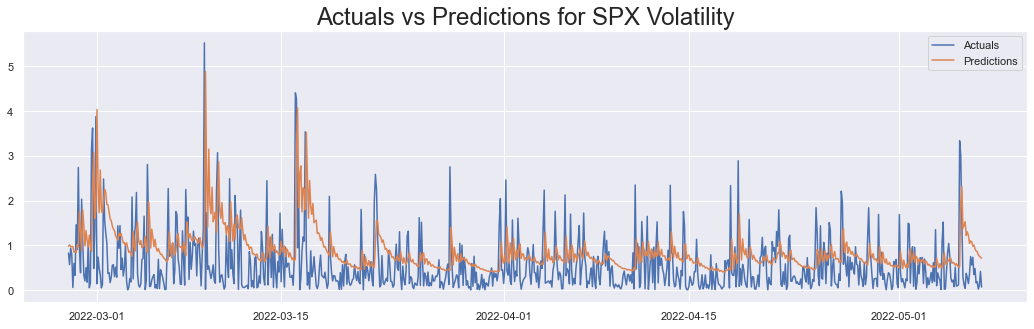

In [37]:
# FORECASTING
# Building Predictions Data
predictions_df = test_df.copy()
# Predictions
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

# PLOTTING FORECASTS
# Setting the Figure Size
plt.rcParams["figure.figsize"] = 18, 5

# Plotting the Predictions and the test data
plt.plot(predictions_df["spx_vol"], label = "Actuals")
plt.plot(predictions_df["Predictions"], label = "Predictions")

# Setting the Title
plt.title("Actuals vs Predictions for SPX Volatility", size = 24)

# Displaying the labels and the plot respectively
plt.legend()
plt.show()

# Parameter Estimation for ARMA Model

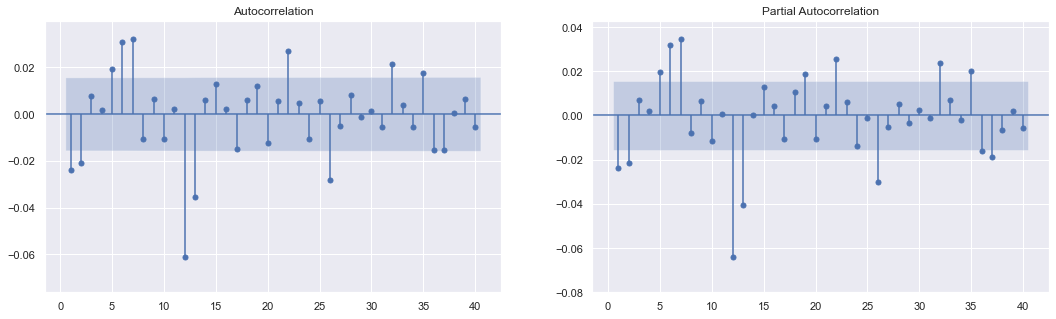

In [45]:
# Importing Required Package
import statsmodels.graphics.tsaplots as sgt

# Fixing plot size
plt.rcParams["figure.figsize"] = 18, 5

# Defining Subplots
fig, axes = plt.subplots(1, 2)

# Plotting ACF and PACF for S&P 500 Returns
sgt.plot_acf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[0], auto_ylims = True)
sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[1], auto_ylims = True)

# Display the Plot
plt.show()

# Tuning parameters for ARMA model

In [39]:
# MODEL FITTING
# Importing Required Package
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the Model
model = SARIMAX(train_df["spx_ret"][1:], order = (1, 0, 1))
# Fitting the Model
model_results = model.fit()

# Printing the model summary
print(model_results.summary())

                               SARIMAX Results                                
Dep. Variable:                spx_ret   No. Observations:                15832
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -23973.685
Date:                Tue, 07 Jun 2022   AIC                          47953.370
Time:                        10:39:11   BIC                          47976.379
Sample:                    07-18-2018   HQIC                         47960.984
                         - 02-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3036      0.140      2.165      0.030       0.029       0.578
ma.L1         -0.3301      0.139     -2.370      0.018      -0.603      -0.057
sigma2         1.2100      0.004    302.343      0.0

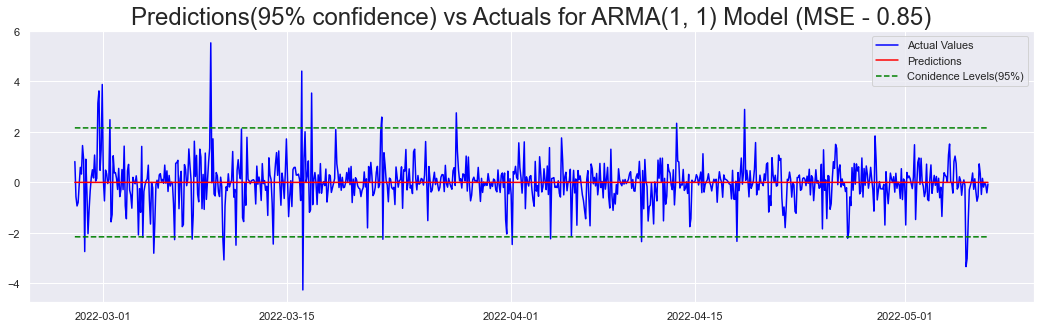

In [40]:
# FORECASTING
# Building Forecast Object to generate Confidence Intervals
arma_forecast = model_results.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# Predictions
arma_predictions_df["Predictions"] = model_results.predict(start = test_df.index[0], end = test_df.index[-1])

# RMSE for the Predictions
arma_rmse = np.sqrt(mean_squared_error(test_df["spx_ret"].values, arma_predictions_df["Predictions"]))


# PLOTTING FORECASTS
# Set the Size of the figure
plt.rcParams["figure.figsize"] = 18, 5

# Plot the Actuals
plt.plot(test_df["spx_ret"], color = "blue", label = "Actual Values")

# Plot the Forecasts and the Confidence Intervals 
plt.plot(arma_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper spx_ret"][test_df.index], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower spx_ret"][test_df.index], color = "green", linestyle = "--")

# Set the Title of the Plot
plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {round(arma_rmse, 2)})", size = 24)

# Display the plot with appropriate labels
plt.legend()
plt.show()

# ARMA Model Residuals


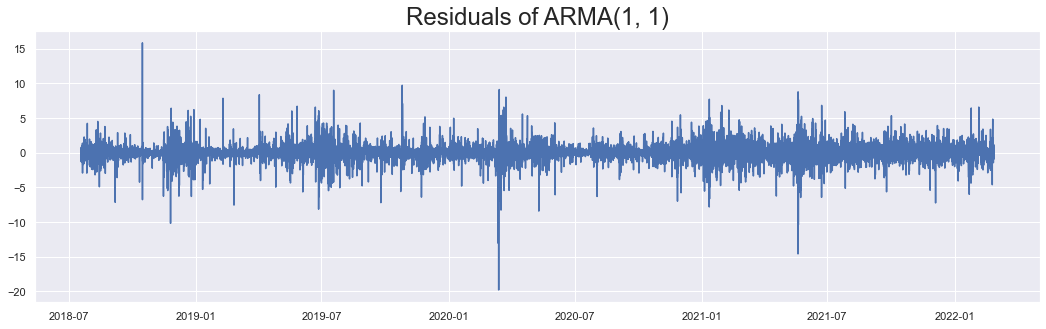

In [41]:
# Set the figure size
plt.rcParams["figure.figsize"] = 18, 5

# Plotting residuals
plt.plot(model_results.resid, label = "Residuals")

# Setting Title
plt.title("Residuals of ARMA(1, 1)", size = 24)

# Display the plot
plt.show()

In [44]:
test_df.shape

(834, 3)

In [43]:
train_df.shape

(15833, 4)

# Tuning parameters for Garch models

# Test

In [53]:
arma_predictions_df["Predictions"]

2022-02-26 20:39:00    0.002362
2022-02-26 22:39:00    0.000717
2022-02-27 00:39:00    0.000218
2022-02-27 02:39:00    0.000066
2022-02-27 04:39:00    0.000020
                         ...   
2022-05-06 22:39:00    0.000000
2022-05-07 00:39:00    0.000000
2022-05-07 02:39:00    0.000000
2022-05-07 04:39:00    0.000000
2022-05-07 06:39:00    0.000000
Freq: 7200S, Name: Predictions, Length: 834, dtype: float64

In [54]:
sum(arma_predictions_df["Predictions"] == 0)

213

In [58]:
test_df["spx_ret"]

Time_UTC_Start
2022-02-26 20:39:00    0.823763
2022-02-26 22:39:00   -0.566739
2022-02-27 00:39:00   -0.933412
2022-02-27 02:39:00   -0.795068
2022-02-27 04:39:00   -0.056917
                         ...   
2022-05-06 22:39:00   -0.187418
2022-05-07 00:39:00   -0.020493
2022-05-07 02:39:00   -0.100265
2022-05-07 04:39:00   -0.415945
2022-05-07 06:39:00   -0.065608
Freq: 7200S, Name: spx_ret, Length: 834, dtype: float64

In [62]:
arma_predictions_df["Predictions"][0]

0.002361776010198248

In [65]:
count = 0
l = test_df["spx_ret"].shape[0]
for i in range(1,l):
    if (test_df['spx_ret'][i]*arma_predictions_df["Predictions"][i] >= 0):
        count += 1
print(count/l)

0.6534772182254197
